## 加载数据集

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from random import Random
from collections import defaultdict

import torch
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.data import DataLoader

from rdkit import Chem
from rdkit.Chem.BRICS import FindBRICSBonds
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit import RDLogger

In [2]:
# -------------------------------------
# attentive_fp fashion featurization
# -------------------------------------
def onehot_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def onehot_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_attr(mol, explicit_H=False, use_chirality=True, pharmaco=True, scaffold=True):
    if pharmaco:
        mol = tag_pharmacophore(mol)
    if scaffold:
        mol = tag_scaffold(mol)

    feat = []
    for i, atom in enumerate(mol.GetAtoms()):
        results = onehot_encoding_unk(
            atom.GetSymbol(),
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At', 'other'
             ]) + onehot_encoding_unk(atom.GetDegree(),
                                      [0, 1, 2, 3, 4, 5, 'other']) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  onehot_encoding_unk(atom.GetHybridization(), [
                      Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                      Chem.rdchem.HybridizationType.SP3D2, 'other'
                  ]) + [atom.GetIsAromatic()]
        if not explicit_H:
            results = results + onehot_encoding_unk(atom.GetTotalNumHs(),
                                                    [0, 1, 2, 3, 4])
        if use_chirality:
            try:
                results = results + onehot_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
            # print(one_of_k_encoding_unk(atom.GetProp('_CIPCode'), ['R', 'S']) + [atom.HasProp('_ChiralityPossible')])
            except:
                results = results + [0, 0] + [atom.HasProp('_ChiralityPossible')]
        if pharmaco:
            results = results + [int(atom.GetProp('Hbond_donor'))] + [int(atom.GetProp('Hbond_acceptor'))] + \
                      [int(atom.GetProp('Basic'))] + [int(atom.GetProp('Acid'))] + \
                      [int(atom.GetProp('Halogen'))]
        if scaffold:
            results = results + [int(atom.GetProp('Scaffold'))]
        feat.append(results)

    return np.array(feat)


def bond_attr(mol, use_chirality=True):
    feat = []
    index = []
    n = mol.GetNumAtoms()
    for i in range(n):
        for j in range(n):
            if i != j:
                bond = mol.GetBondBetweenAtoms(i, j)
                if bond is not None:
                    bt = bond.GetBondType()
                    bond_feats = [
                        bt == Chem.rdchem.BondType.SINGLE, bt == Chem.rdchem.BondType.DOUBLE,
                        bt == Chem.rdchem.BondType.TRIPLE, bt == Chem.rdchem.BondType.AROMATIC,
                        bond.GetIsConjugated(),
                        bond.IsInRing()
                    ]
                    if use_chirality:
                        bond_feats = bond_feats + onehot_encoding_unk(
                            str(bond.GetStereo()),
                            ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"])
                    feat.append(bond_feats)
                    index.append([i, j])

    return np.array(index), np.array(feat)


def bond_break(mol):
    results = np.array(sorted(list(FindBRICSBonds(mol))), dtype=np.long)

    if results.size == 0:
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(mol, asMols=True, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(mol)

    else:
        bond_to_break = results[:, 0, :]
        bond_to_break = bond_to_break.tolist()
        with Chem.RWMol(mol) as rwmol:
            for i in bond_to_break:
                rwmol.RemoveBond(*i)
        rwmol = rwmol.GetMol()
        cluster_idx = []
        Chem.rdmolops.GetMolFrags(rwmol, asMols=True, sanitizeFrags=False, frags=cluster_idx)
        fra_edge_index, fra_edge_attr = bond_attr(rwmol)
        cluster_idx = torch.LongTensor(cluster_idx)

    return fra_edge_index, fra_edge_attr, cluster_idx

In [3]:
# ---------------------------------------------
# Scaffold and pharmacophore information utils
# ---------------------------------------------
# tag pharmoco features to each atom
fun_smarts = {
        'Hbond_donor': '[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]',
        'Hbond_acceptor': '[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),n&X2&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]',
        'Basic': '[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))]),$([n;X2;+0;-0])]',
        'Acid': '[C,S](=[O,S,P])-[O;H1,-1]',
        'Halogen': '[F,Cl,Br,I]'
        }
FunQuery = dict([(pharmaco, Chem.MolFromSmarts(s)) for (pharmaco, s) in fun_smarts.items()])


def tag_pharmacophore(mol):
    for fungrp, qmol in FunQuery.items():
        matches = mol.GetSubstructMatches(qmol)
        match_idxes = []
        for mat in matches:
            match_idxes.extend(mat)
        for i, atom in enumerate(mol.GetAtoms()):
            tag = '1' if i in match_idxes else '0'
            atom.SetProp(fungrp, tag)
    return mol


# tag scaffold information to each atom
def tag_scaffold(mol):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    match_idxes = mol.GetSubstructMatch(core)
    for i, atom in enumerate(mol.GetAtoms()):
        tag = '1' if i in match_idxes else '0'
        atom.SetProp('Scaffold', tag)
    return mol

In [4]:
# ---------------------------------
# data and dataset
# ---------------------------------
class MolData(Data):
    def __init__(self, fra_edge_index=None, fra_edge_attr=None, cluster_index=None, **kwargs):
        super(MolData, self).__init__(**kwargs)
        self.cluster_index = cluster_index
        self.fra_edge_index = fra_edge_index
        self.fra_edge_attr = fra_edge_attr

    def __inc__(self, key, value, *args, **kwargs):
        if key == 'cluster_index':
            return int(self.cluster_index.max()) + 1
        else:
            return super().__inc__(key, value, *args, **kwargs)


class MolDataset(InMemoryDataset):

    def __init__(self, root, dataset, task_type, tasks,
                 transform=None, pre_transform=None, pre_filter=None):

        self.tasks = tasks
        self.dataset = dataset
        self.task_type = task_type

        super(MolDataset, self).__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['{}.csv'.format(self.dataset)]

    @property
    def processed_file_names(self):
        return ['{}.pt'.format(self.dataset)]

    def download(self):
        pass

    def process(self):
        df = pd.read_csv(self.raw_paths[0])
        smilesList = df.smiles.values
        print(f'number of all smiles: {len(smilesList)}')
        remained_smiles = []
        canonical_smiles_list = []
        for smiles in smilesList:
            try:
                canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
                remained_smiles.append(smiles)
            except:
                print(f'not successfully processed smiles: {smiles}')
                pass
        print(f'number of successfully processed smiles: {len(remained_smiles)}')

        df = df[df["smiles"].isin(remained_smiles)].reset_index()
        target = df[self.tasks].values
        smilesList = df.smiles.values
        data_list = []

        for i, smi in enumerate(tqdm(smilesList)):

            mol = Chem.MolFromSmiles(smi)
            data = self.mol2graph(mol)

            if data is not None:
                label = target[i]
                data.y = torch.LongTensor([label])
                if self.task_type == 'regression':
                    data.y = torch.FloatTensor([label])
                data_list.append(data)

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def mol2graph(self, mol):
        smiles = Chem.MolToSmiles(mol)
        if mol is None: return None
        node_attr = atom_attr(mol)
        edge_index, edge_attr = bond_attr(mol)
        fra_edge_index, fra_edge_attr, cluster_index = bond_break(mol)
        data = MolData(
            x=torch.FloatTensor(node_attr),
            edge_index=torch.LongTensor(edge_index).t(),
            edge_attr=torch.FloatTensor(edge_attr),
            fra_edge_index=torch.LongTensor(fra_edge_index).t(),
            fra_edge_attr=torch.FloatTensor(fra_edge_attr),
            cluster_index=torch.LongTensor(cluster_index),
            y=None,
            smiles=smiles,
        )
        return data

## 定义模型

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster

In [6]:
# ---------------------------------------
# Attention layers
# ---------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y

In [7]:
# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = x_j.view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

    def __repr__(self):
        return '{}({}, {}, slices={})'.format(self.__class__.__name__,
                                              self.in_channels,
                                              self.out_channels, self.slices)

In [8]:
# ---------------------------------------
# HiGNN backbone
# ---------------------------------------
class HiGNN(torch.nn.Module):
    """Hierarchical informative graph neural network for molecular representation.

    """

    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4, brics=True, cl=False):
        super(HiGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att
        self.brics = brics
        self.cl = cl

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        if self.brics:
            # mol-fra attention
            self.cross_att = GATConv(hidden_channels, hidden_channels, heads=4,
                                     dropout=dropout, add_self_loops=False,
                                     negative_slope=0.01, concat=False)

        if self.brics:
            self.out = Linear(2 * hidden_channels, out_channels)
        else:
            self.out = Linear(hidden_channels, out_channels)

        if self.cl:
            self.lin_project = Linear(hidden_channels, int(hidden_channels/2))

        self.reset_parameters()

    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        if self.brics:
            self.cross_att.reset_parameters()

        self.out.reset_parameters()

        if self.cl:
            self.lin_project.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol = global_add_pool(x, batch)
        mol_vec = global_add_pool(x, batch).relu_()

        if self.brics:
            # get fragment input
            fra_x = data.x
            fra_edge_index = data.fra_edge_index
            fra_edge_attr = data.fra_edge_attr
            cluster = data.cluster_index

            fra_x = F.relu(self.lin_a(fra_x))  # (N, 46) -> (N, hidden_channels)
            fra_edge_attr = F.leaky_relu_(self.lin_b(fra_edge_attr))  # (N, 10) -> (N, hidden_channels)

            # fragment convs block
            for i in range(0, self.num_layers):
                fra_h = F.relu(self.atom_convs[i](fra_x, fra_edge_index, fra_edge_attr))
                beta = self.lin_gate(torch.cat([fra_x, fra_h, fra_x - fra_h], 1)).sigmoid()
                fra_x = beta * fra_x + (1 - beta) * fra_h
                if self.f_att:
                    fra_x = self.feature_att(fra_x, cluster)

            fra_x = global_add_pool(fra_x, cluster).relu_()

            # get fragment batch
            cluster, perm = consecutive_cluster(cluster)
            fra_batch = pool_batch(perm, data.batch)

            # molecule-fragment attention
            row = torch.arange(fra_batch.size(0), device=batch.device)
            mol_fra_index = torch.stack([row, fra_batch], dim=0)
            fra_vec, att = self.cross_att((fra_x, mol_vec), mol_fra_index, return_attention_weights=True)
            fra = fra_vec
            fra_vec = fra_vec.relu()

            vectors_concat = list()
            vectors_concat.append(mol_vec)
            vectors_concat.append(fra_vec)

            out = torch.cat(vectors_concat, 1)

            # molecule-fragment contrastive
            if self.cl:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), self.lin_project(mol_vec).relu_(), self.lin_project(fra_vec).relu_()
            else:
                out = F.dropout(out, p=self.dropout, training=self.training)
                return self.out(out), mol, fra

        else:
            assert self.cl is False
            out = F.dropout(mol_vec, p=self.dropout, training=self.training)
            return self.out(out)

In [10]:
def load_best_result(model):
    best_ckpt_path = 'E:/3-Code/Jupternote book/HiGNN_Explainability/bbbp_best_ckpt_2026.pth'
    ckpt = torch.load(best_ckpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['model'])

    return model

In [11]:
# ---------------------------------------
# Build HiGNN 
# ---------------------------------------
model = HiGNN(in_channels=46,
              hidden_channels=128,
              out_channels=2,
              edge_dim=10,
              num_layers=2,
              dropout=0.4,
              slices=1,
              f_att=True,
              r=4,
              brics=True,
              cl=False)

model = load_best_result(model)
print(model)

HiGNN(
  (lin_a): Linear(in_features=46, out_features=128, bias=True)
  (lin_b): Linear(in_features=10, out_features=128, bias=True)
  (atom_convs): ModuleList(
    (0): NTNConv(128, 128, slices=1)
    (1): NTNConv(128, 128, slices=1)
  )
  (lin_gate): Linear(in_features=384, out_features=128, bias=True)
  (feature_att): FeatureAttention(
    (mlp): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=False)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=32, out_features=128, bias=False)
    )
  )
  (cross_att): GATConv(128, 128, heads=4)
  (out): Linear(in_features=256, out_features=2, bias=True)
)


In [12]:
path = 'E:/3-Code/Jupternote book/HiGNN_Explainability'
dataset = 'bbbp'
task_type = 'classification'
tasks = 'p_np'
bbbp = MolDataset(root=path, dataset=dataset, task_type=task_type, tasks=tasks)

In [13]:
seed = 2026
random = Random(seed)
indices = list(range(len(bbbp)))
random.seed(seed)
random.shuffle(indices)

train_size = int(0.8 * len(bbbp))
val_size = int(0.1 * len(bbbp))
test_size = len(bbbp) - train_size - val_size

trn_id, val_id, test_id = indices[:train_size], \
                          indices[train_size:(train_size + val_size)], \
                          indices[(train_size + val_size):]
len(test_id)

205

In [15]:
bbbp = bbbp[test_id]

In [16]:
len(bbbp)

205

In [17]:
loader = DataLoader(bbbp, batch_size=205)

In [18]:
iter_ = iter(loader)
batch = next(iter_)

In [19]:
y = batch.y.numpy().tolist()
y

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [24]:
model.eval()  # 关闭dropout
out, mol, fra = model(batch)

In [34]:
batch

Batch(batch=[5063], cluster_index=[5063], edge_attr=[10920, 10], edge_index=[2, 10920], fra_edge_attr=[9622, 10], fra_edge_index=[2, 9622], ptr=[206], smiles=[205], x=[5063, 46], y=[205])

In [25]:
mol = mol.detach().numpy().tolist()
fra = fra.detach().numpy().tolist()

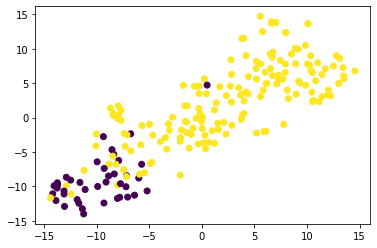

In [49]:
# mol
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(mol)
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=y)
plt.show()

In [56]:
x_tsne

array([[-1.65007191e+01, -1.14762173e+01],
       [ 1.13681049e+01,  1.10996447e+01],
       [ 1.14731884e+01,  1.04175587e+01],
       [ 3.85316563e+00,  3.13365316e+00],
       [-1.53662338e+01, -1.10073214e+01],
       [ 1.41729422e+01,  1.44221430e+01],
       [-2.36548233e+00, -6.46821165e+00],
       [ 1.14518776e+01,  1.26014118e+01],
       [ 2.53033042e+00,  2.12770319e+00],
       [-1.10867243e+01, -8.35241318e+00],
       [-1.41457558e+01, -9.41045856e+00],
       [-4.73873281e+00, -5.39231586e+00],
       [ 9.24367809e+00,  1.09863453e+01],
       [ 3.02360067e-03, -1.76586008e+00],
       [ 5.68102074e+00,  5.67550564e+00],
       [ 1.26076775e+01,  1.14407253e+01],
       [-1.13438950e+01, -5.35233450e+00],
       [-1.03138390e+01, -3.19949126e+00],
       [-1.12171257e+00, -4.88214827e+00],
       [ 3.72766399e+00,  1.58482337e+00],
       [ 5.61925411e+00,  3.40981913e+00],
       [-6.65300226e+00, -6.92250252e+00],
       [ 4.84943151e+00,  2.97223687e+00],
       [ 9.

In [57]:
mol_df = pd.DataFrame(x_tsne)

In [60]:
mol_df.to_csv('bbbp_test_fra.csv',index=False)

In [59]:
mol_df['label'] = y
mol_df['smiles'] = batch.smiles

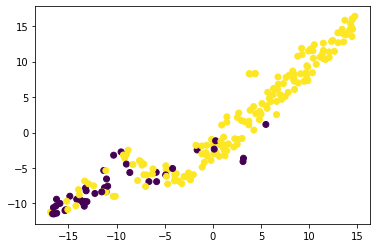

In [55]:
# fra
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(fra)
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=y)
plt.show()

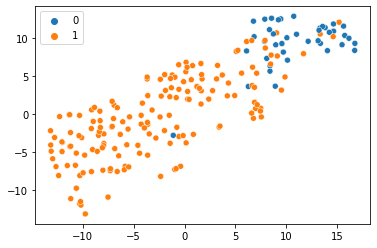

In [46]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, init='pca', random_state=0)
x_tsne = tsne.fit_transform(mol)
sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue=y)
plt.show()

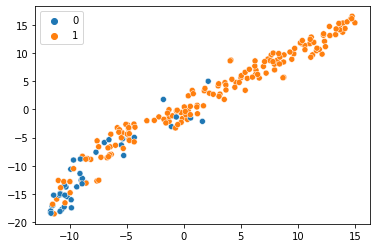

In [29]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(fra)
sns.scatterplot(x=x_tsne[:,0],y=x_tsne[:,1],hue=y)
plt.show()